# Exploratory data analysis (EDA)

## Data Sources

The dataset is available in Kaggle (link:         https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance ). This dataset was available as a part of Azure AI Notebooks for Predictive Maintenance.


### Dataset Description:
There are 5 CSV files consisting of:

- <b>Telemetry Time Series Data (PdM_telemetry.csv):</b> Telemetry is the automated communication processes from multiple data sources. It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.


- <b>Error (PdM_errors.csv):</b> These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.


- <b>Maintenance (PdM_maint.csv):</b> If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations:

    During the regular scheduled visit, the technician replaced it (Proactive Maintenance)
    A component breaks down and then the technician does an unscheduled maintenance to replace the       component (Reactive Maintenance). This is considered as a failure and corresponding data is           captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to     the closest hour since the telemetry data is collected at an hourly rate.
    

- <b>Failures (PdM_failures.csv):</b> Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.


- <b>Metadata of Machines (PdM_Machines.csv):</b> Model type & age of the Machines.


The data comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In [1]:
#Importing libraries
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("Solarize_Light2")
%matplotlib inline

In [2]:
#Loading all the dataset using Pandas library
import pandas as pd

telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

In [3]:
#Creating some utilities functions:
#https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/code

def check_null(df):
    """
    Returns percentage of rows containing missing data
    """
    return df.isna().sum() * 100/len(df)


def get_missing_dates(series, start_date, end_date, freq="D"):
    """
    Returns the dates which are missing in the series
    date_sr between the start_date and end_date
    
    series: Series consisting of date
    start_date: Start date in String format
    end_date: End date in String format
    """
    return pd.date_range(
        start=start_date, end=end_date, freq=freq).difference(series)


def check_duplicate(df, subset):
    """
    Returns if there are any duplicate rows in the DataFrame.
    
    df: DataFrame under consideration
    subset: Optional List of feature names based on which 
            duplicate rows are being identified. 
    """
    if subset is not None: 
        return df.duplicated(subset=subset, keep=False).sum()
    else:
        return df.duplicated(keep=False).sum()


def create_date_features(source_df, target_df, feature_name):
    '''
    Create new features related to dates
    
    source_df : DataFrame consisting of the timestamp related feature
    target_df : DataFrame where new features will be added
    feature_name : Name of the feature of date type which needs to be decomposed.
    '''
    target_df.loc[:, 'year'] = source_df.loc[:, feature_name].dt.year.astype('uint16')
    target_df.loc[:, 'month'] = source_df.loc[:, feature_name].dt.month.astype('uint8')
    target_df.loc[:, 'quarter'] = source_df.loc[:, feature_name].dt.quarter.astype('uint8')
    target_df.loc[:, 'weekofyear'] = source_df.loc[:, feature_name].dt.isocalendar().week.astype('uint8')
    
    target_df.loc[:, 'hour'] = source_df.loc[:, feature_name].dt.hour.astype('uint8')
    
    target_df.loc[:, 'day'] = source_df.loc[:, feature_name].dt.day.astype('uint8')
    target_df.loc[:, 'dayofweek'] = source_df.loc[:, feature_name].dt.dayofweek.astype('uint8')
    target_df.loc[:, 'dayofyear'] = source_df.loc[:, feature_name].dt.dayofyear.astype('uint8')
    target_df.loc[:, 'is_month_start'] = source_df.loc[:, feature_name].dt.is_month_start
    target_df.loc[:, 'is_month_end'] = source_df.loc[:, feature_name].dt.is_month_end
    target_df.loc[:, 'is_quarter_start']= source_df.loc[:, feature_name].dt.is_quarter_start
    target_df.loc[:, 'is_quarter_end'] = source_df.loc[:, feature_name].dt.is_quarter_end
    target_df.loc[:, 'is_year_start'] = source_df.loc[:, feature_name].dt.is_year_start
    target_df.loc[:, 'is_year_end'] = source_df.loc[:, feature_name].dt.is_year_end
    
    # This is of type object
    target_df.loc[:, 'month_year'] = source_df.loc[:, feature_name].dt.to_period('M')
    
    return target_df


def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    

def plot_hist(df, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


    

def plot_ts(series, figsize=(20, 6), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_barh(df, feature_name, normalize=True, 
              kind='barh', figsize=(15,5), sort_index=False, title=None):
    """
    Plot barh for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    else:   
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    
    plt.legend()
    plt.show()


def plot_boxh(df, feature_name, kind='box', log=True):
    """
    Box plot
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='box', vert=False, 
                                                  figsize=(10, 6), 
                                                  title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='box', vert=False, 
                              figsize=(10, 6), 
                              title=f'Distribution of {feature_name}')
    plt.show()
    

def plot_scatter(df, feature_x, feature_y, figsize=(10,10), 
                 title=None, xlabel=None, ylabel=None):
    """
    Plot scatter     
    """
    df.plot.scatter(feature_x, feature_y, 
                    figsize=(8, 6), title=title, 
                    legend=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### Telemetry Time Series Data (PdM_telemetry.csv)

Displaying the first 5 records in the dataset. A summary of the whole dataset is also provided.

In [4]:
# Format datetime field which comes in as string

telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))
print(telemetry.head())
print()#print blank space
print("Summary of the dataset:")
telemetry.describe()

Total number of telemetry records: 876100
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  

Summary of the dataset:


,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


<b>How many Machines are there?

In [5]:
telemetry.machineID.nunique()

100

<b>What is the duration of the data?

In [6]:
telemetry.datetime.describe(datetime_is_numeric=True)

count                           876100
mean     2015-07-02 17:59:59.999988992
min                2015-01-01 06:00:00
25%                2015-04-02 12:00:00
50%                2015-07-02 18:00:00
75%                2015-10-02 00:00:00
max                2016-01-01 06:00:00
Name: datetime, dtype: object

<b> Observation: </b> <br>
1. Telemetry data is distributed between 1st Jan 2015 to 1st Jan 2016. 
2. It seems that the data is having hourly frequency.

<b>Are there any missinge days in the data?

In [7]:
get_missing_dates(telemetry.datetime, 
                  start_date="2015-01-01 06:00:00", 
                  end_date="2016-01-01 06:00:00", 
                  freq='H')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

<b> Observation: </b> <br>
1. There is no missing data.


<b>Are there any duplicates?</b> <br>
One Machine should not have multiple rows with the same time stamp.

In [8]:
check_duplicate(telemetry, ['datetime', 'machineID'])

0

<b> Observation: </b> <br>
1. There are no duplicates in the telemetry data.


<b>Are there any Null values in the data?

In [9]:
check_null(telemetry)

datetime     0.0
machineID    0.0
volt         0.0
rotate       0.0
pressure     0.0
vibration    0.0
dtype: float64

<b> Observation: </b> <br>
1. There are no missing values in the data.


<b>Let's plot Vibration of Machine 55 for 2015

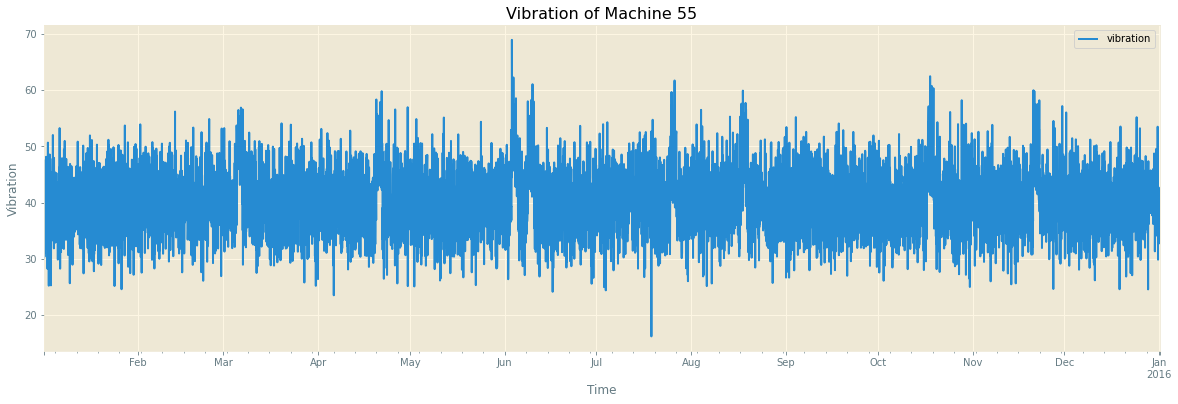

In [10]:
# Let's plot Vibration of Machine 55 for 2015
df_vib_machine_1 = telemetry[
    telemetry.machineID == 55][["datetime", "vibration"]].set_index("datetime")
plot_ts(df_vib_machine_1, title="Vibration of Machine 55", xlabel="Time", ylabel="Vibration")

<b> Observation: </b> <br>
1. The Highest vibration is 70 (approx.) for machine ID=55 in 2015.
2. The Lowest vibration is 15 (approx.) for machine ID=55 in 2015.

<b>As an example, below is a plot of voltage values for machine ID=1 for the first half of 2015.

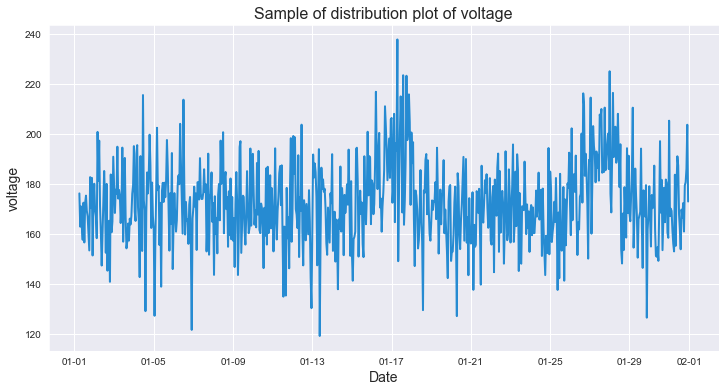

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'volt']]

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage',fontsize=14)

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d'
plt.xlabel('Date',fontsize=14)
plt.title("Sample of distribution plot of voltage", fontsize=16)
plt.show()

<b> Observation: </b> <br>
1. The Highest voltage is 240 (approx.) for machine ID=1 during the period.
2. The Lowest voltage is 120 for machine ID=1 during the period.

<b>Let's add date related features to the telemetry data:

In [12]:
telemetry_df = create_date_features(telemetry, telemetry, "datetime")
telemetry_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,year,month,quarter,weekofyear,...,day,dayofweek,dayofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,month_year
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01


<b>Plot the distribution of voltage across various months

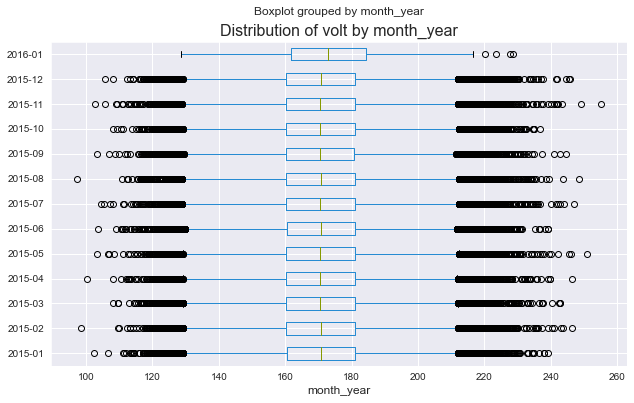

In [13]:
plot_boxh_groupby(telemetry, feature_name="volt", by="month_year")

<b> Observation: </b> <br>
1. It shows the voltage across Machines are not varying over month.
2. We can ignore the entry for 2016 since we have only one day data in 2016.


<b>Let's plot it just for Machine 66.

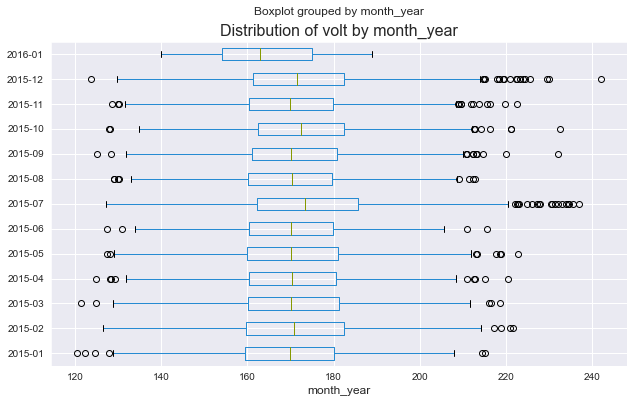

In [14]:
plot_boxh_groupby(telemetry[telemetry.machineID == 66], feature_name="volt", by="month_year")

<b> Observation: </b> <br>
1. From the above plot, there is not much variation of voltage across months. 

<b>Let's plot the distribution of Voltage across Machines.

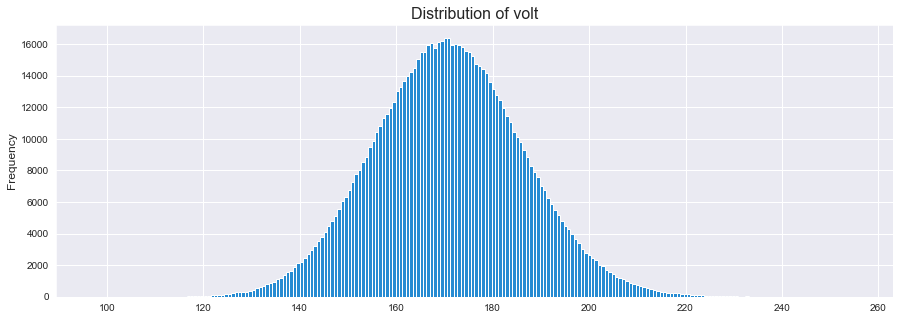

In [15]:
sns.set_style("darkgrid")
plot_hist(telemetry, feature_name="volt", log=False, bins=222)

<b> Observation: </b> <br>
1. The distribution of 'volt' looks like a normal distribution. However statistical test is to be carried out to verify the distribution.  


<b> <font color='red'> Let's do statistical test (Anderson-Darling Test) for checking whether the 'volt' feature follows normal distribution or not

<font color='blue'>H0 (null hypothesis) = The data set is drawn from a Normal/Gaussian distribution.<br>
Significance level (alpha) to interpret the p-value = 5% 

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.


In [16]:
#https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
#https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/#:~:text=Anderson%2DDarling%20Test,-Anderson%2DDarling%20Test&text=It%20can%20be%20used%20to,called%20the%20Kolmogorov%2DSmirnov%20test.
from scipy.stats import anderson
data_volt = telemetry_df['volt']
result = anderson(data_volt)
print(result)
print("#"*77)
print('result.statistic: %.3f' % result.statistic)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

AndersonResult(statistic=61.56284168898128, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
#############################################################################
result.statistic: 61.563
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


<b> Observation: </b> <br>
1. From the above Anderson-Darling Test, we can conclude that 'volt' data is not following Normal/Gaussian distribution.  

<b> <font color='red'> Let's plot QQ plot to verify distribution '['rotate', 'pressure', 'vibration']' feature are normal or not.

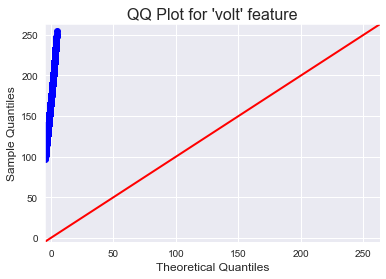

In [17]:
#https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import pylab as py
qq_data_volt = telemetry_df['volt']
sm.qqplot(qq_data_volt, line ='45')
plt.title("QQ Plot for 'volt' feature")
py.show()

<b> Observation: </b> <br>
1. From the above QQ plot, we can conclude that 'volt' data is not following Normal/Gaussian distribution.
  

<b>Let's verify it by plotting histogram of other parameters.

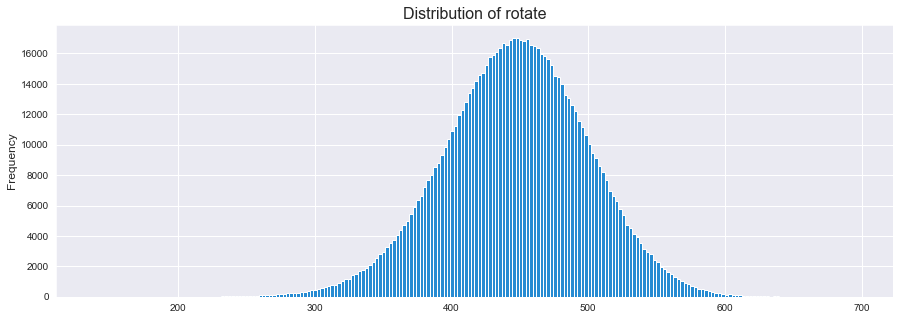

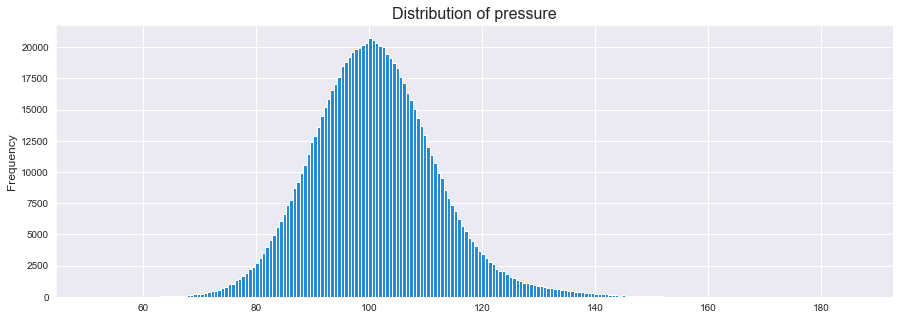

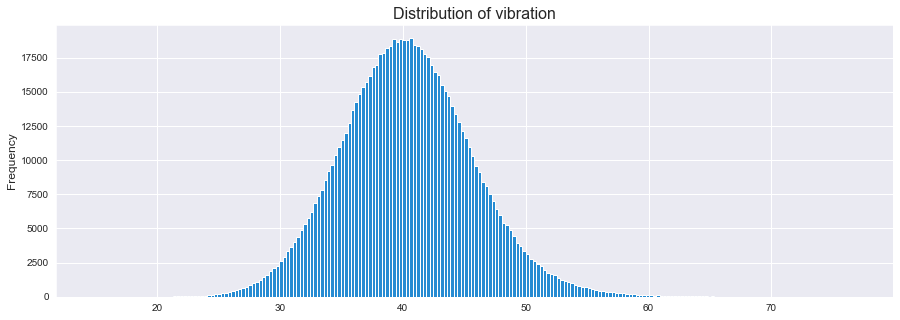

In [18]:
for name in ['rotate', 'pressure', 'vibration']:
    plot_hist(telemetry, feature_name=name, log=False, bins=222)

<b> Observation: </b> <br>
1. The distribution of Vibration, rotation and pressure look like a normal distribution. However statistical test is to be carried out to verify the distribution.  


<b> <font color='red'> Let's do statistical test (Anderson-Darling Test) for checking whether the ['rotate', 'pressure', 'vibration'] follows normal distribution or not

<font color='blue'>H0 (null hypothesis) = The data set is drawn from a Normal/Gaussian distribution.<br>
Significance level (alpha) to interpret the p-value = 5% 

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.


In [19]:
#https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
#https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/#:~:text=Anderson%2DDarling%20Test,-Anderson%2DDarling%20Test&text=It%20can%20be%20used%20to,called%20the%20Kolmogorov%2DSmirnov%20test.
from scipy.stats import anderson
data_rotate = telemetry_df['rotate']
result = anderson(data_rotate)
print(result)
print("#"*77)
print('result.statistic: %.3f' % result.statistic)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

AndersonResult(statistic=167.677045869641, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
#############################################################################
result.statistic: 167.677
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [20]:
#https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
#https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/#:~:text=Anderson%2DDarling%20Test,-Anderson%2DDarling%20Test&text=It%20can%20be%20used%20to,called%20the%20Kolmogorov%2DSmirnov%20test.
from scipy.stats import anderson
data_pressure = telemetry_df['pressure']
result = anderson(data_pressure)
print(result)
print("#"*77)
print('result.statistic: %.3f' % result.statistic)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

AndersonResult(statistic=1216.243362900219, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
#############################################################################
result.statistic: 1216.243
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [21]:
#https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
#https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/#:~:text=Anderson%2DDarling%20Test,-Anderson%2DDarling%20Test&text=It%20can%20be%20used%20to,called%20the%20Kolmogorov%2DSmirnov%20test.
from scipy.stats import anderson
data_vibration = telemetry_df['vibration']
result = anderson(data_vibration)
print(result)
print("#"*77)
print('result.statistic: %.3f' % result.statistic)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

AndersonResult(statistic=469.85137929650955, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
#############################################################################
result.statistic: 469.851
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


<b> Observation: </b> <br>
1. From the above Anderson-Darling Test, we can conclude that 'rotate','pressure' and 'vibration' data are not following Normal/Gaussian distribution.
  

<b> <font color='red'> Let's plot QQ plot to verify distribution '['rotate', 'pressure', 'vibration']' feature are normal or not.

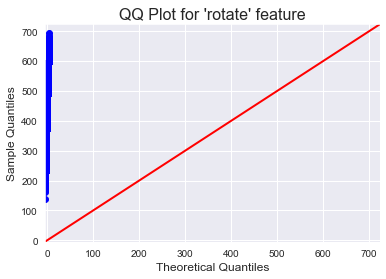

In [22]:
#https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import pylab as py
qq_data_rotate = telemetry_df['rotate']
sm.qqplot(qq_data_rotate, line ='45')
plt.title("QQ Plot for 'rotate' feature")
py.show()

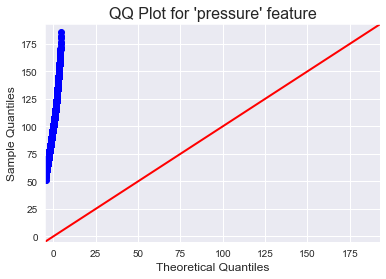

In [23]:
#https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import pylab as py
qq_data_pressure = telemetry_df['pressure']
sm.qqplot(qq_data_pressure, line ='45')
plt.title("QQ Plot for 'pressure' feature")
py.show()

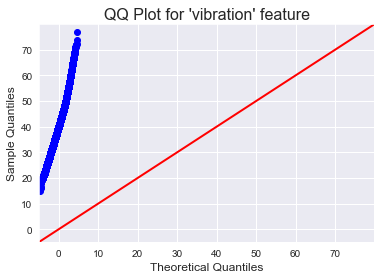

In [24]:
#https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import pylab as py
qq_data_vibration = telemetry_df['vibration']
sm.qqplot(qq_data_vibration, line ='45')
plt.title("QQ Plot for 'vibration' feature")
py.show()

<b> Observation: </b> <br>
1. From the above QQ plot, we can conclude that 'rotate','pressure' and 'vibration' data are not following Normal/Gaussian distribution.  

<b> <font color='red'> Multivariate probability density plot

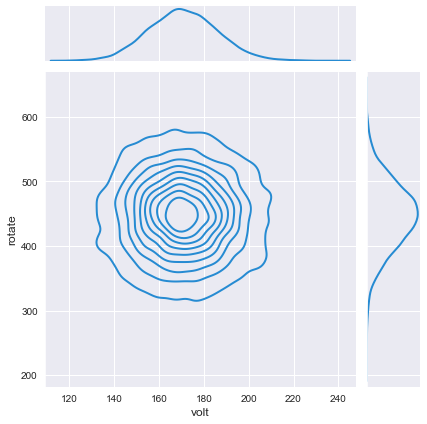

In [25]:
#2D Density plot, contors-plot for top 10,000 points (Taking more time to load all the data points)
mul_data = telemetry_df.head(10000)
sns.jointplot(x="volt", y="rotate", data=mul_data, kind="kde")
plt.show()


<b> Observation: </b> <br>
1. The most of data point of 'volt' feature is varied from 160 to 180.
2. The most of data point of 'rotate' feature is varied from 410 to 490.

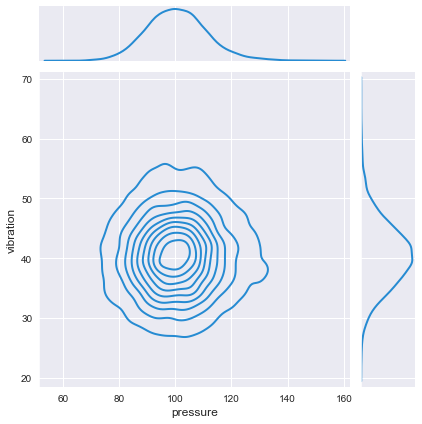

In [26]:
#2D Density plot, contors-plot
mul_data = telemetry_df.head(10000)
sns.jointplot(x="pressure", y="vibration", data=mul_data, kind="kde")
plt.show()

<b> Observation: </b> <br>
1. The most of data point of 'pressure' feature is varied from 90 to 110.
2. The most of data point of 'vibration' feature is varied from 35 to 45.

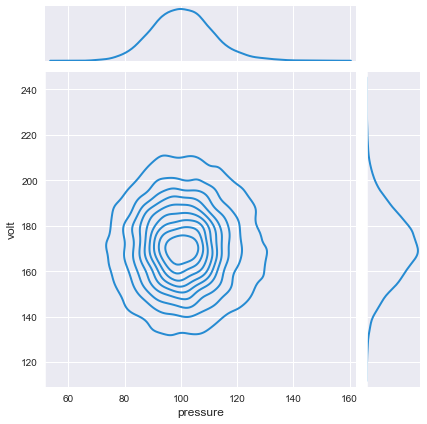

In [27]:
#2D Density plot, contors-plot
mul_data = telemetry_df.head(10000)
sns.jointplot(x="pressure", y="volt", data=mul_data, kind="kde")
plt.show()

<b> Observation: </b> <br>
1. The most of data point of 'pressure' feature is varied from 90 to 110.
2. The most of data point of 'volt' feature is varied from 160 to 180.

<b>Observations on Telemetry Data set</b>
- The data distributed between 1st Jan 2015 to 1st Jan 2016.
- Each row represents the state of a machine on a particular hour. Voltage, vibration, pressure &       rotation of a machine have been averaged hourly.
- There are 100 unique Machines.
- There are no duplicates or missing values in the dataset.
- The four parameters voltage, vibration, pressure & rotation are not normally distributed as per    Anderson-Darling Test and QQ plot.

### Errors Dataset (PdM_errors.csv)

This data includes the errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [28]:
# Format datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

print("Total number of error records: %d" % len(errors.index))
print(errors.head())

Total number of error records: 3919
             datetime  machineID errorID
0 2015-01-03 07:00:00          1  error1
1 2015-01-03 20:00:00          1  error3
2 2015-01-04 06:00:00          1  error5
3 2015-01-10 15:00:00          1  error4
4 2015-01-22 10:00:00          1  error4


<b>Are there any duplicates?</b><br>
One Machine should not have multiple errors with the same time stamp

In [29]:
check_duplicate(errors, ['datetime', 'machineID', 'errorID'])

0

There are no duplicates in the error data.

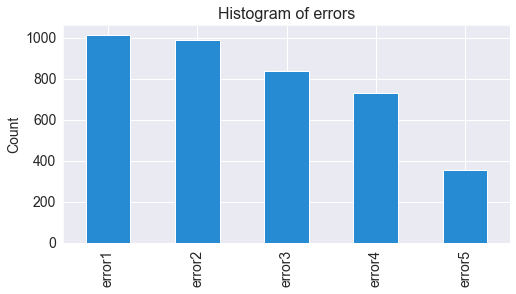

In [30]:
#Plotting the histogram of errors.
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
errors['errorID'].value_counts().plot(kind='bar', fontsize=14)
plt.title("Histogram of errors", fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.show()

<b> Observation: </b> <br>
1. Type 1 & 2 errors are most frequent which is more than double the numbers of error-5.
2. Root cause analysis should be carried out to reduce the Type 1 & 2 errors to reduce the maintenance time and cost. 

<b>Let's check if the errors are uniformly occurring across machines.

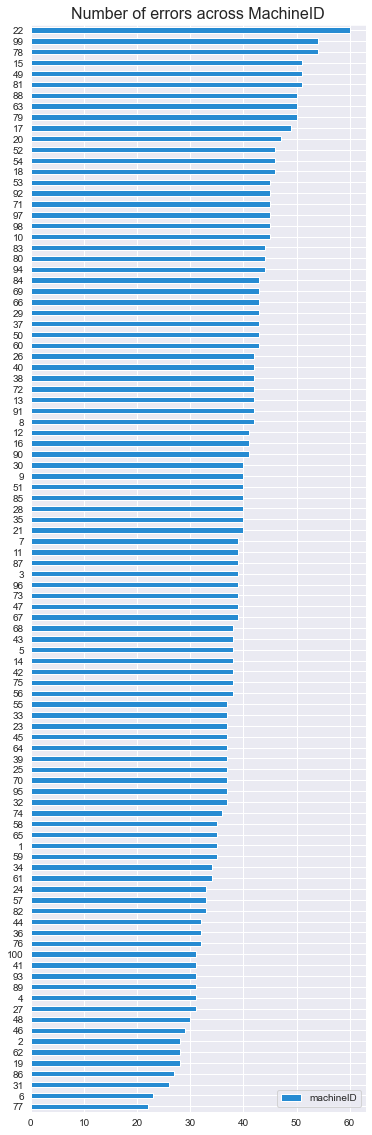

In [31]:
plot_barh(errors, "machineID", figsize=(6, 20), normalize=False,\
          title="Number of errors across MachineID")

<b> Observation: </b> <br>
1. Number of errors are varied across different machines.
2. Machine ID-22 is the highest numbers of errors (around 60 nos) encountered.
3. Machine ID-77 is the lowest numbers of errors (around 20 nos) encountered.

<b>How does the Machine to type of error distribution looks like?

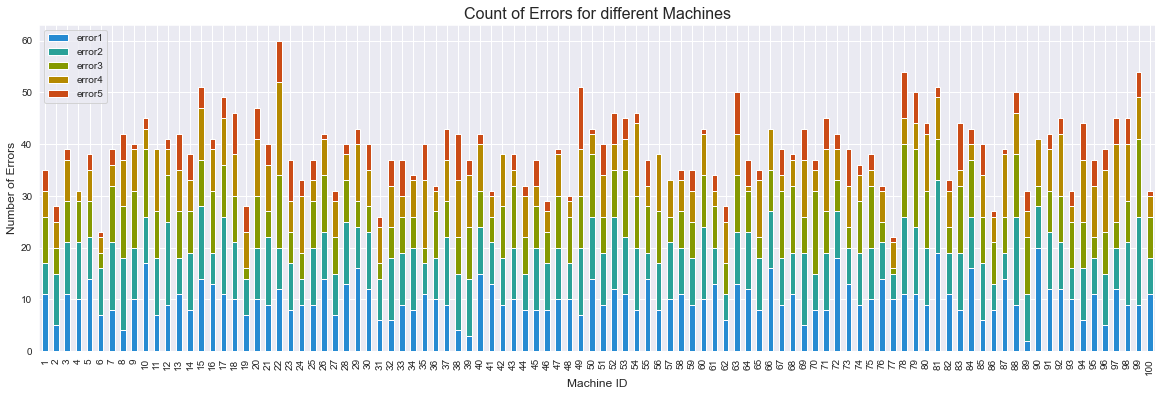

In [32]:
df_errors = errors.groupby(["machineID", "errorID"]).size().reset_index()
df_errors.columns = ["machineID", "errorID", "errorValues"]

df_errors_pivot = pd.pivot(df_errors, index="machineID", columns="errorID", \
                           values="errorValues").rename_axis(None, axis=1)

df_errors_pivot.plot.bar(stacked=True, figsize=(20, 6), \
                         title="Count of Errors for different Machines")

plt.xlabel("Machine ID")
plt.ylabel("Number of Errors")
plt.show()

<b> Observation: </b> <br>
1. Machine ID-22 is the highest numbers of errors (around 60 nos) encountered where error-4 occurred around 15 times (highest as compared with other errors). The lowest error-5 occurred around 9 times.
2. Machine ID-77 is the lowest numbers of errors (around 20 nos) encountered where error-1 occurred around 10 times (highest as compared with other errors). The lowest error-5 occurred around 1 times.

<b>Plot number of errors across Machines over days

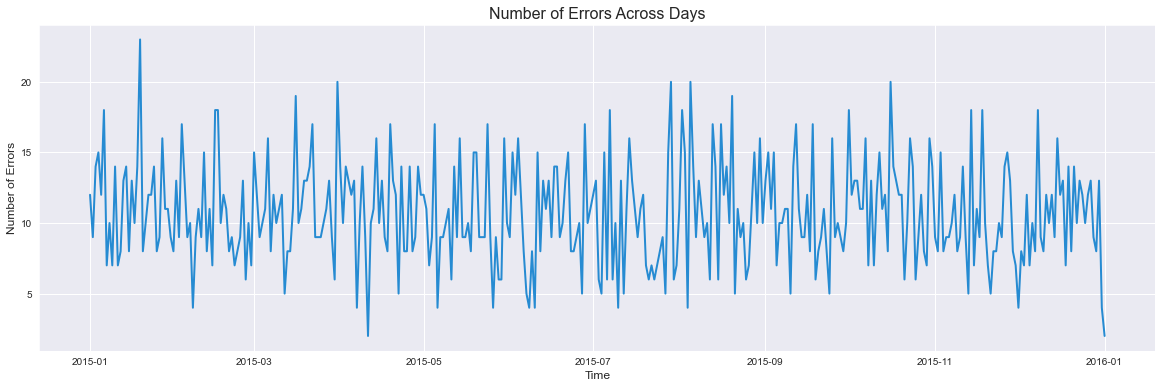

In [33]:
plot_ts(
    errors.datetime.dt.date.value_counts().sort_index(), 
    figsize=(20, 6), 
    title="Number of Errors Across Days", 
    xlabel="Time",
    ylabel="Number of Errors")

<b> Observation: </b> <br>
1. The Highest number of errors (less than 25) are encountered across days.
2. In 2016 and 2015, one (1) number of error is encountered on a particular day.

<b>How does the error distribution looks for a particular machine?

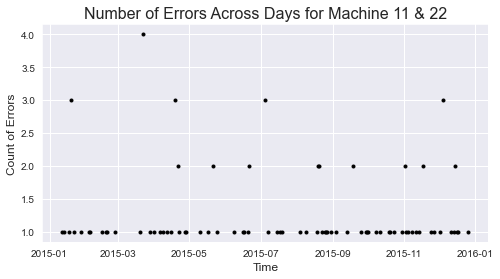

In [34]:
df_temp = errors[errors.machineID.isin([11, 22])].datetime.dt.date.value_counts().sort_index()
df_temp.plot(style="k.", figsize=(8, 4), title="Number of Errors Across Days for Machine 11 & 22")
plt.ylabel("Count of Errors")
plt.xlabel("Time")
plt.show()

<b> Observation: </b> <br>
1. For Machine 11 & 22, for most of the days, number of error is 1. But there are few days when number of errors are more than 1.
2. Four (4) numbers of errors are encountered on a particular day for Machine 11 & 22.

<b>Let's plot the distribution of the number of errors per day across Machine.

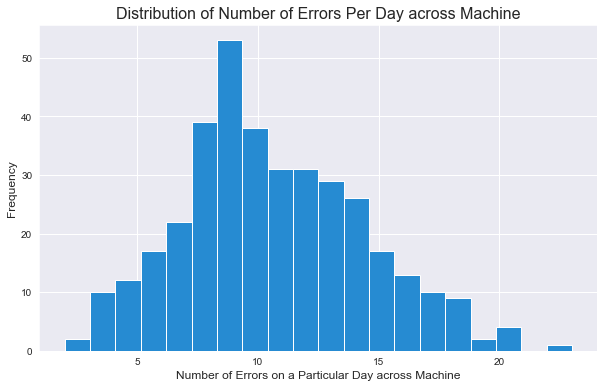

In [35]:
errors['date'] = errors.datetime.dt.date

errors.groupby('date').size().hist(bins=20, figsize=(10, 6))
plt.title("Distribution of Number of Errors Per Day across Machine")
plt.xlabel("Number of Errors on a Particular Day across Machine")
plt.ylabel("Frequency")
plt.show()

<b> Observation: </b> <br>
1. Around average 12 nos errors are encountered per day across 100 nos Machine.

###  Maintenance (PdM_maint.csv)

If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations:

- During the regular scheduled visit, the technician replaced it (Proactive Maintenance)
- A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [36]:
# Format datetime field which comes in as string
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print("Total number of maintenance records: %d" % len(maint.index))
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


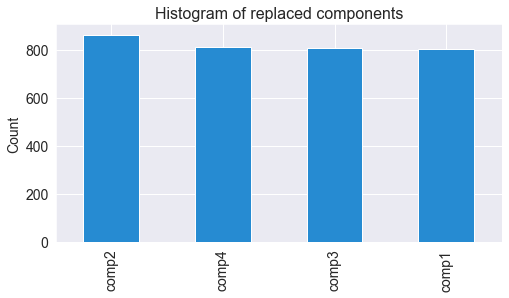

In [37]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
maint['comp'].value_counts().plot(kind='bar',fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Histogram of replaced components", fontsize=16)
plt.show()

<b> Observation: </b> <br>
1. Four types of components are replaced almost in the same numbers (around 800 times each).

In [38]:
for name in ["machineID", "comp"]:
    maint[name] = maint[name].astype("category")
    
maint.sort_values(["datetime", "machineID", "comp"], inplace=True)

# Add date related features.
maint_df = create_date_features(maint, maint, "datetime")

<b>What is the duration of the data?

In [39]:
maint_df.datetime.describe(datetime_is_numeric=True)

count                             3286
mean     2015-05-30 14:40:36.518551552
min                2014-06-01 06:00:00
25%                2015-03-03 06:00:00
50%                2015-06-13 06:00:00
75%                2015-09-18 00:00:00
max                2016-01-01 06:00:00
Name: datetime, dtype: object

<b> Observation: </b> <br>
1. Maintenance data is present June 2014 onwards. This is different from other data which are present between 2014 and 2015.

In [40]:
get_missing_dates(maint_df.datetime, 
                  start_date="2014-06-01 06:00:00", 
                  end_date="2016-01-01 06:00:00", 
                  freq='H')

DatetimeIndex(['2014-06-01 07:00:00', '2014-06-01 08:00:00',
               '2014-06-01 09:00:00', '2014-06-01 10:00:00',
               '2014-06-01 11:00:00', '2014-06-01 12:00:00',
               '2014-06-01 13:00:00', '2014-06-01 14:00:00',
               '2014-06-01 15:00:00', '2014-06-01 16:00:00',
               ...
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00',
               '2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00'],
              dtype='datetime64[ns]', length=13523, freq=None)

<b>Let's plot number of maintenance records across months

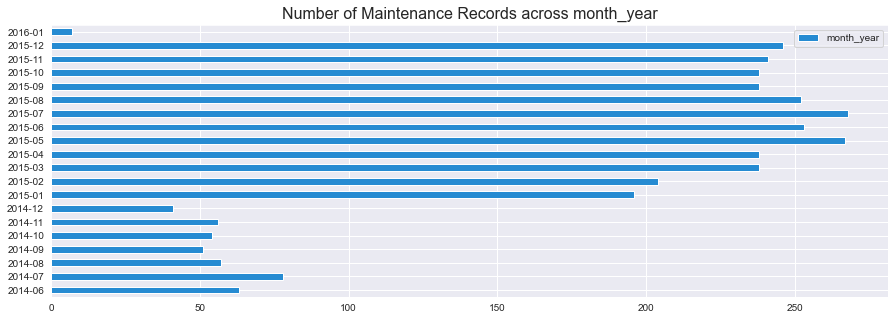

In [41]:
plot_barh(maint, "month_year", 
          normalize=False, 
          title="Number of Maintenance Records across month_year",
          sort_index=True)

<b> Observation: </b> <br>
1. Maintenance records are available from June'2014 to January'2016.
2. Number of components replaced in the year 2015 are considerably higher compared to the 2014.
3. In 2015, number of maintenance records are the highest in May and July month. 
4. We can ignore the data for 2016 (since we have only one day's data).

<b>Let's plot the number of Maintenance Records Across Machines

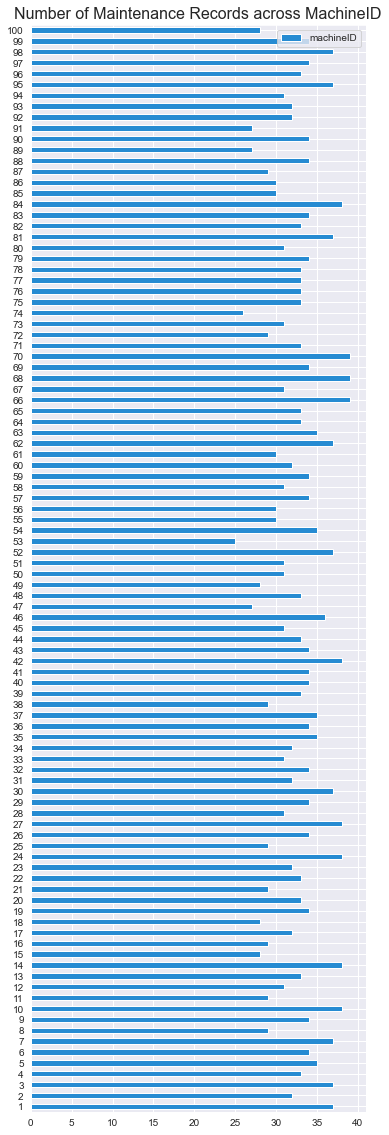

In [42]:
plot_barh(maint, "machineID", 
          figsize=(6, 20), 
          normalize=False, 
          title="Number of Maintenance Records across MachineID", 
          sort_index=True)

<b> Observation: </b> <br>
1. Machine ID-66, 68 & 70 are the highest number of Maintenance Records machines.
2. Machine ID-53 is the lowest number of Maintenance Record machine.

<b>How does the Machine to different component replaced looks like?

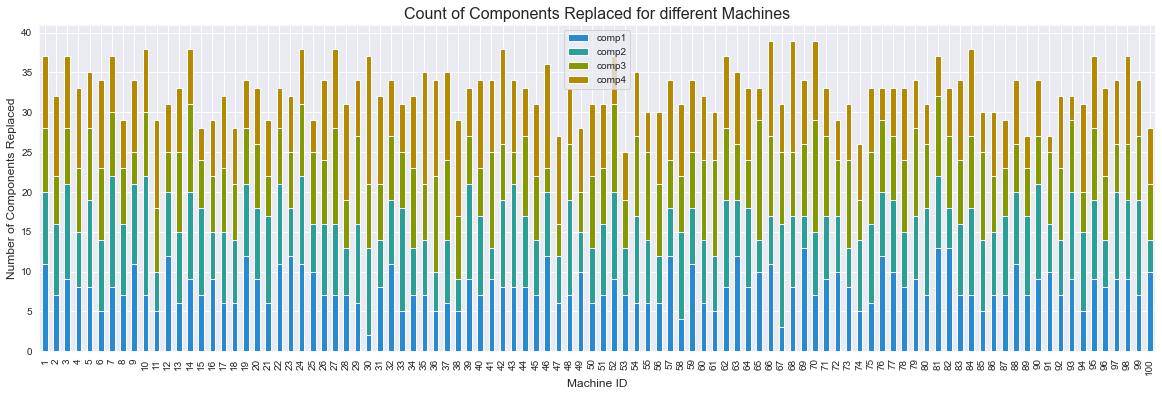

In [43]:
df_maint = maint_df.groupby(["machineID", "comp"]).size().reset_index()
df_maint.columns = ["machineID", "comp", "num_comp"]
df_maint_pivot = pd.pivot(df_maint, index="machineID", columns="comp",
                          values="num_comp").rename_axis(None, axis=1)

df_maint_pivot.plot.bar(stacked=True, figsize=(20, 6), 
                        title="Count of Components Replaced for different Machines")

plt.xlabel("Machine ID")
plt.ylabel("Number of Components Replaced")
plt.show()

<b> Observation: </b> <br>
1. Machine ID-66, 68 & 70 are the highest components replaced machines.
2. Machine ID-53 is the lowest components replaced machine.

<b>Plot number of Maintenance Issues raised per day.

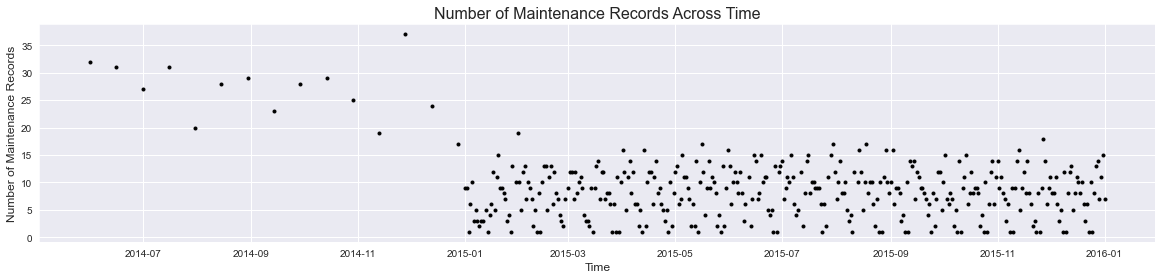

In [44]:
maint.datetime.dt.date.value_counts().plot(
    style="k.", 
    figsize=(20, 4), 
    title="Number of Maintenance Records Across Time")
plt.ylabel("Number of Maintenance Records")
plt.xlabel("Time")
plt.show()

<b> Observation: </b> <br>
1. There is a drastic difference between the number of maintenance records in 2014 vs 2015.

### Metadata of Machines (PdM_Machines.csv)

This data set includes some information about the machines: model type and age (years in service).

In [45]:
machines['model'] = machines['model'].astype('category')

print("Total number of machines: %d" % len(machines.index))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


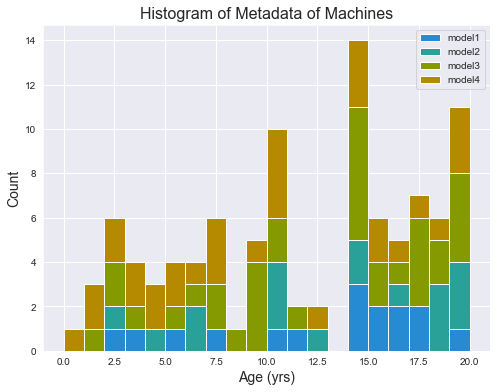

In [46]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Histogram of Metadata of Machines",fontsize=16)
plt.legend()
plt.show()

<b> Observation: </b> <br>
1. For machine age having 2.5 years, numbers of model-3 and model-4 have the highest.
2. For machine age having around 10 years, numbers of model-2 and model-4 have the highest.
3. For machine age having around 20 years, numbers of model-1 is the less quantity as compare to other models. <br>Quantity of Model-2, model-3 and model-4 are almost same.


<b>Plot the distribution of age of the Machines.

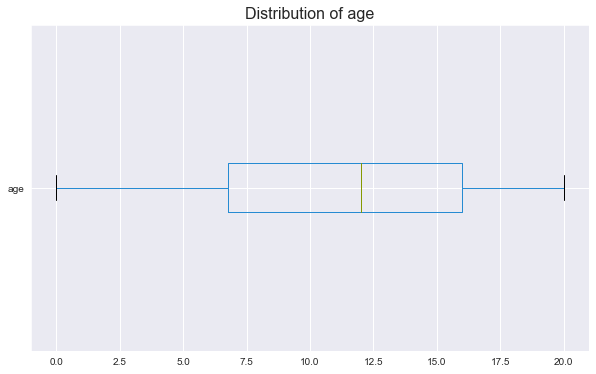

In [47]:
plot_boxh(machines, feature_name="age", log=False)

<b> Observation: </b> <br>
1. The age of the Machines is distributed between 0 to 20. The median age is to ~12.5. 
2. There is no outlier.
3. Around 75% of machines age is less than 16 years.
4. Around 25% of machines age is less than 7 years.

<b>Create a Data Frame with number of errors, maintenance records and failure records across machines.

In [48]:
# Create a DF with number of errors, maintenance records and failure records across machines

# Create a DF consisting of number of erros across Machines
erros_across_machine = errors.groupby("machineID").size()
erros_across_machine = pd.DataFrame(erros_across_machine, columns=["num_errors"]).reset_index()

machines_errors_df = pd.merge(machines, erros_across_machine, how='left', on="machineID")

# Create a DF consisting of number of maintenance records across Machines
maint_across_machine = maint.groupby("machineID").size()
maint_across_machine = pd.DataFrame(maint_across_machine, columns=["num_maint"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, maint_across_machine, how='left', on="machineID")

# Create a DF consisting of number of failure records across Machines
failure_across_machine = failures.groupby("machineID").size()
failure_across_machine = pd.DataFrame(failure_across_machine, columns=["num_failure"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, failure_across_machine, how='left', on="machineID")

machines_errors_df.head()

,machineID,model,age,num_errors,num_maint,num_failure
0,1,model3,18,35,37,7.0
1,2,model4,7,28,32,4.0
2,3,model3,8,39,37,5.0
3,4,model3,7,31,33,6.0
4,5,model3,2,38,35,7.0


<b>Plot Number of Errors across Machine Age.

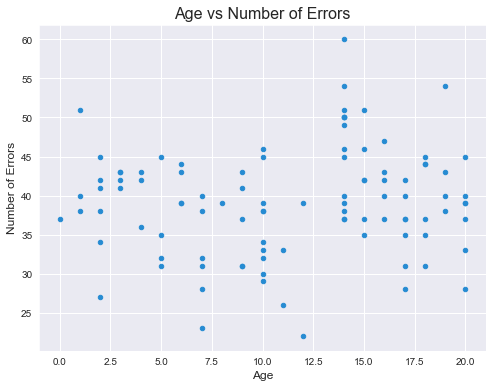

In [49]:
plot_scatter(machines_errors_df, "age", "num_errors", 
             title="Age vs Number of Errors", 
             xlabel="Age", ylabel="Number of Errors")

<b>Plot Age vs Number of Maintenance Records.

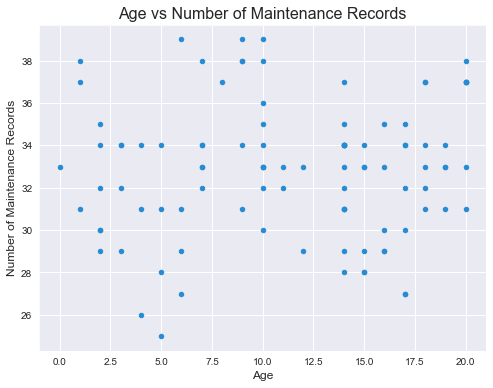

In [50]:
plot_scatter(machines_errors_df, "age", "num_maint", 
             title="Age vs Number of Maintenance Records", 
             xlabel="Age", ylabel="Number of Maintenance Records")

<b>Plot Age vs Number of Failure Records.

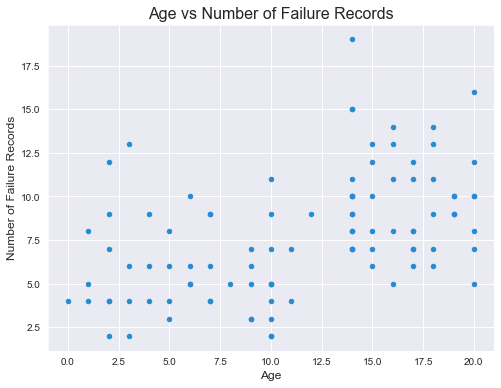

In [51]:
plot_scatter(machines_errors_df, "age", "num_failure", 
             title="Age vs Number of Failure Records", 
             xlabel="Age", ylabel="Number of Failure Records")

From the above three plots, it appears only Number of Failures is slightly correlated with Age.
Let's verify it with a correlation values.

In [52]:
machines_errors_df.corr()

,age,num_errors,num_maint,num_failure
age,1.000000,0.106931,0.075445,0.476459
num_errors,0.106931,1.000000,-0.026558,0.483735
num_maint,0.075445,-0.026558,1.000000,-0.030258
num_failure,0.476459,0.483735,-0.030258,1.000000


<b> Observation: </b> <br>From the above correlation values, it is observed that nos. of failure is correlated with machine age and nos. of errors.

###  Failures (PdM_failures.csv)

These are the records of component replacements due to failures. Each record has a date and time, machine ID, and failed component type.

In [53]:
# Format datetime field which comes in as string.

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


<b> Below is the histogram of the failures due to each component. 

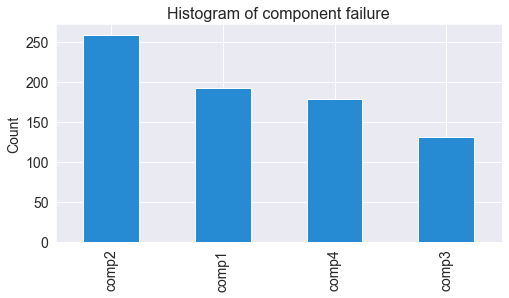

In [54]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Histogram of component failure", fontsize=16)
plt.show()

<b> Observation: </b> <br>The most failures happen due to component-2. And number of failures of component-2 is more than double the failure of component-3. So, it is better to find the root cause of this failure to minimize the equipment failure cases. 

# Let's plot tsne 

In [55]:
#Load the combine dataframe saved during First cut approach (Merger all the data sets).
final_df = pd.read_csv('final_df_first_cut.csv')
final_df.head(5)

,datetime,machineID,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,...,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4,failure
0,01-01-2015 6.00,1,176.217853,418.504078,113.077935,45.087686,0,0,0,0,...,0,0,0,0,18,0,0,1,0,none
1,01-01-2015 7.00,1,162.879223,402.747490,95.460525,43.413973,0,0,0,0,...,0,0,0,0,18,0,0,1,0,none
2,01-01-2015 8.00,1,170.989902,527.349825,75.237905,34.178847,0,0,0,0,...,0,0,0,0,18,0,0,1,0,none
3,01-01-2015 9.00,1,162.462833,346.149335,109.248561,41.122144,0,0,0,0,...,0,0,0,0,18,0,0,1,0,none
4,01-01-2015 10.00,1,157.610021,435.376873,111.886648,25.990511,0,0,0,0,...,0,0,0,0,18,0,0,1,0,none


In [56]:
data = final_df.drop(['datetime', 'machineID', 'failure'], 1)
data.head(2)

,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4
0,176.217853,418.504078,113.077935,45.087686,0,0,0,0,0,0,0,0,0,18,0,0,1,0
1,162.879223,402.747490,95.460525,43.413973,0,0,0,0,0,0,0,0,0,18,0,0,1,0


In [57]:
labels=final_df['failure']
labels.head(2)

0    none
1    none
Name: failure, dtype: object

In [58]:
labels.unique()

array(['none', 'comp4', 'comp1', 'comp2', 'comp3'], dtype=object)

In [59]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(data)
print(standardized_data.shape)

(877209, 18)


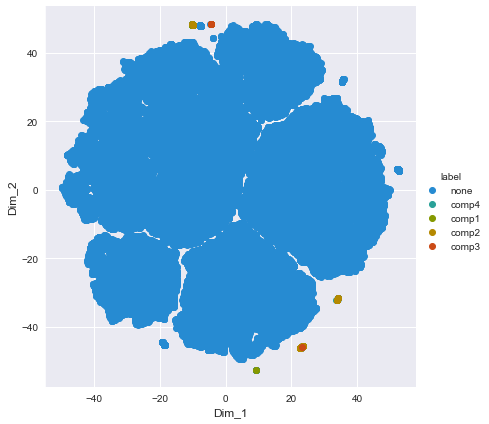

In [60]:
# TSNE plot

from sklearn.manifold import TSNE

# Picking the top 1,00,000 points as TSNE takes a lot of time for 8,77,209 points
data_100000 = standardized_data[0:100000,:]
labels_100000 = labels[0:100000]

model = TSNE(n_components=2, random_state=0,  n_jobs=-1)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_100000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_100000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

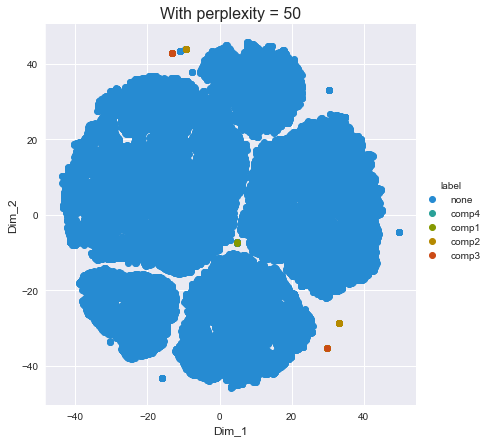

In [61]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_jobs=-1)
tsne_data = model.fit_transform(data_100000) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_100000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 100000 samples in 26.988s...
[t-SNE] Computed neighbors for 100000 samples in 50.820s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional prob

[t-SNE] Iteration 600: error = 3.8657446, gradient norm = 0.0002074 (50 iterations in 34.644s)
[t-SNE] Iteration 650: error = 3.7480414, gradient norm = 0.0001831 (50 iterations in 35.949s)
[t-SNE] Iteration 700: error = 3.6475003, gradient norm = 0.0001614 (50 iterations in 33.798s)
[t-SNE] Iteration 750: error = 3.5606287, gradient norm = 0.0001421 (50 iterations in 34.750s)
[t-SNE] Iteration 800: error = 3.4848680, gradient norm = 0.0001259 (50 iterations in 34.978s)
[t-SNE] Iteration 850: error = 3.4177709, gradient norm = 0.0001128 (50 iterations in 35.100s)
[t-SNE] Iteration 900: error = 3.3576734, gradient norm = 0.0001014 (50 iterations in 36.061s)
[t-SNE] Iteration 950: error = 3.3032415, gradient norm = 0.0000915 (50 iterations in 37.084s)
[t-SNE] Iteration 1000: error = 3.2539580, gradient norm = 0.0000837 (50 iterations in 34.924s)
[t-SNE] Iteration 1050: error = 3.2089539, gradient norm = 0.0000766 (50 iterations in 33.997s)
[t-SNE] Iteration 1100: error = 3.1677051, gradi

[t-SNE] Iteration 4900: error = 2.4723880, gradient norm = 0.0000116 (50 iterations in 53.168s)
[t-SNE] Iteration 4950: error = 2.4715438, gradient norm = 0.0000115 (50 iterations in 53.461s)
[t-SNE] Iteration 5000: error = 2.4707642, gradient norm = 0.0000113 (50 iterations in 52.026s)
[t-SNE] KL divergence after 5000 iterations: 2.470764


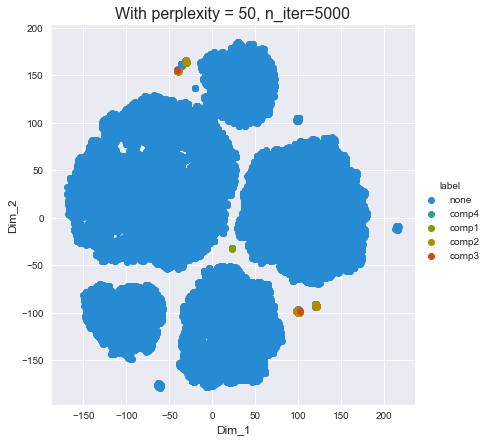

In [62]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000, n_jobs=-1, verbose=2)
tsne_data = model.fit_transform(data_100000) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_100000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.show()

<b> Observation on t-SNE plot: </b> <br>
1. With different perplexity and numbers of iteration, t-SNE plot are almost stable.

2. From the above t-SNE plot, it is observed that failure due to different components are almost separated in different clusters, so ML may be applied to predict the component failure of machine.

#Reference: https://www.displayr.com/using-t-sne-to-visualize-data-before-prediction/

<b> <font color='blue'>Overall Summary of EDA:</b> <br>
All the specific observations are mentioned above under each plot and findings. Overall summary of EDA is stated below:
1. There are 5 numbers of CSV files are downloaded from Kaggle and details of data sets are stated below: 

  (a) Telemetry Time Series Data (PdM_telemetry.csv): - It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

 (b) Error (PdM_errors.csv):- These are errors encountered by the machines while in operating condition. These errors don't shut down the machines.

  (c) Maintenance (PdM_maint.csv): - All replaced components of a machine are captured in this file.

  (d) Failures (PdM_failures.csv): - Each data point represents replacement of a component due to failure.

  (e) Metadata of Machines (PdM_Machines.csv): - Model type & age of the Machines.

2. There is no missing data available in all the CSV files.

3. Performed statistical test (Anderson-Darling Test and QQ plot) on Telemetry Time Series Data set, it is observed that the distribution of ‘volt’, 'rotate',' pressure' and 'vibration' are not following Normal/Gaussian distribution in spite of looks like normal distribution.

4. There are 5 numbers of errors (total errors: 3919 nos.) are encountered by machines. Type 1 & 2 errors are most frequent which is more than double the numbers of error-5. Root cause analysis should be carried out to reduce the Type 1 & 2 errors to reduce the maintenance time and cost.

5. Highest numbers of error (around 60 nos) is encountered at Machine ID-22 whereas Machine ID-77 is the lowest numbers of errors (around 20 nos) encountered. Root cause analysis should be carried out to reduce the numbers of error of Machine ID-22 to reduce the maintenance time and cost.

6. Average 12 numbers (approx.) of errors are encountered per day across 100 numbers Machine.

7. There are total 3286 numbers of maintenance records available in Maintenance data set. The data set have 04 (four) types of components mentioned and those are replaced almost in the same numbers (around 800 times each).

8. Maintenance records are available from June'2014 to January'2016. In 2015, number of maintenance records are the highest in May and July month.

9. The highest number of Maintenance Records are found in Machine ID-66, 68 & 70. Machine ID-53 is the lowest number of Maintenance Record machine.

10. The age of Machines is distributed between 0 to 20 years. The median age is 12.5 years (approx.).  Around 75% of machines age is less than 16 years and around 25% of machines age is less than 7 years.

11. After computing correlation values, it is observed that nos. of failure are correlated with machine age and nos. of errors.

12. There are total 761 numbers of failures are stated in the Failures data set. The most failures happened due to component-2. And number of failures of component-2 is more than double the failure of component-3. So, it is better to find the root cause of this failure to minimize the equipment failure cases in future.

13. From the t-SNE plot, it is observed that failure due to different components are almost separated in different clusters, so Machine Learning (ML) may be applied to predict the component failure of machine before it occurs.


# >>>>> End of EDA of case study-1 <<<<<<<